In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from collections import Counter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, learning_curve
import warnings
from matplotlib.pyplot import ylim
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb

/home/phe002/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic
import time

In [3]:
cv = StratifiedKFold(n_splits=5,random_state=42)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
  
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    return plt

In [4]:
dataset = pd.read_csv('featureEngineering.csv',index_col=0)
dataset.drop(['name_(10, 20]','Age_(-10, 0]','Fare','name_(30, 40]','name_(40, 50]',
          'name_(50, 100]','Age_(0, 10]'],axis=1,inplace=True)
test = pd.read_csv('test.csv')
PassengerId = test['PassengerId']
train_len = len(pd.read_csv('train.csv'))
print dataset.columns

Index([u'Survived', u'Sex', u'SibSp0', u'SibSp1', u'SibSp2', u'Parch0',
       u'Parch1', u'Parch2', u'Parch3', u'Fsize0', u'Fsize1', u'Fsize2',
       u'Fsize3', u'Fsize4', u'Title_Master', u'Title_girl', u'Title_men',
       u'Title_women', u'Cabin_B', u'Cabin_C', u'Cabin_D', u'Cabin_E',
       u'Cabin_X', u'T_1', u'T_2', u'T_3', u'T_A', u'T_P', u'Em_C', u'Em_S',
       u'Pc_1', u'Pc_2', u'Pc_3'],
      dtype='object')


In [5]:
pdtest = dataset[train_len:].drop(labels=["Survived"],axis = 1)
y_train = dataset[:train_len]["Survived"].values.astype(int)
pdx_train = dataset[:train_len].drop(labels = ["Survived"],axis = 1)

test = pdtest.values
x_train = pdx_train.values

#x_train, test, y_train, ytest = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
print x_train.shape
print y_train.shape
print test.shape
#print xtrain.shape
#print ytrain.shape
#print xtest.shape
#print ytest.shape

(891, 32)
(891,)
(418, 32)


In [6]:
time0= time.time()
cv = StratifiedKFold(n_splits=5,random_state=42)
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,30)),
    'max_features': hp.choice('max_features', range(4,30)),
    'min_samples_leaf': hp.choice('min_samples_leaf',range(2,20)),
    'n_estimators': hp.choice('n_estimators', range(500,600)),
    'criterion': hp.choice('criterion', ["gini"]),
    'n_jobs': hp.choice('n_jobs', [10]), 
    'min_samples_split': hp.choice('min_samples_split',range(2,40)),
    'random_state':hp.choice('random_state',[7])
}
maxacc=0
def f(params):
    clf = RandomForestClassifier(**params)
    acc = cross_val_score(clf, x_train, y_train,cv=cv,n_jobs=10).mean()
    global maxacc
    if acc > maxacc:
        maxacc = acc
        print 'new best:', maxacc, params
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
print fmin(f, space4rf, algo=tpe.suggest, max_evals=50, trials=trials)
print time.time()-time0
#10 - 1min
#600 1h

new best: 0.824936812603 {'n_jobs': 10, 'min_samples_leaf': 10, 'n_estimators': 566, 'max_features': 29, 'random_state': 7, 'criterion': 'gini', 'min_samples_split': 9, 'max_depth': 12}
new best: 0.826035228902 {'n_jobs': 10, 'min_samples_leaf': 16, 'n_estimators': 550, 'max_features': 24, 'random_state': 7, 'criterion': 'gini', 'min_samples_split': 26, 'max_depth': 2}
new best: 0.828326643112 {'n_jobs': 10, 'min_samples_leaf': 2, 'n_estimators': 517, 'max_features': 24, 'random_state': 7, 'criterion': 'gini', 'min_samples_split': 22, 'max_depth': 4}
new best: 0.83056762798 {'n_jobs': 10, 'min_samples_leaf': 2, 'n_estimators': 503, 'max_features': 15, 'random_state': 7, 'criterion': 'gini', 'min_samples_split': 22, 'max_depth': 4}
{'n_jobs': 0, 'min_samples_leaf': 0, 'n_estimators': 3, 'min_samples_split': 20, 'random_state': 0, 'criterion': 0, 'max_features': 11, 'max_depth': 3}
118.09830904


In [7]:
time0= time.time()
space4et = {
    'max_features': hp.choice('max_features', range(4,30)),
    'n_estimators': hp.choice('n_estimators', range(500,600)),
    'criterion': hp.choice('criterion', ["gini"]),
    "max_depth": hp.choice('max_depth', range(1,30)),
    'min_samples_leaf': hp.choice('min_samples_leaf',range(2,20)),
     'n_jobs': hp.choice('n_jobs', [-1]),  
    'min_samples_split': hp.choice('min_samples_split',range(2,40)),
    'random_state':hp.choice('random_state',[7])
}
maxacc=0
def f(params):
    clf = ExtraTreesClassifier(**params)
    acc = cross_val_score(clf, x_train, y_train,cv=cv,n_jobs=-1).mean()
    global maxacc
    if acc > maxacc:
        maxacc = acc
        print 'new best:', maxacc, params
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best= fmin(f, space4et, algo=tpe.suggest, max_evals=50, trials=trials)
print best
print time.time()-time0

new best: 0.821578580226 {'n_jobs': -1, 'min_samples_leaf': 9, 'n_estimators': 500, 'max_features': 5, 'random_state': 7, 'criterion': 'gini', 'min_samples_split': 7, 'max_depth': 26}
new best: 0.823844744302 {'n_jobs': -1, 'min_samples_leaf': 10, 'n_estimators': 529, 'max_features': 8, 'random_state': 7, 'criterion': 'gini', 'min_samples_split': 17, 'max_depth': 27}
new best: 0.831684946416 {'n_jobs': -1, 'min_samples_leaf': 13, 'n_estimators': 590, 'max_features': 21, 'random_state': 7, 'criterion': 'gini', 'min_samples_split': 37, 'max_depth': 3}
new best: 0.832802264852 {'n_jobs': -1, 'min_samples_leaf': 8, 'n_estimators': 599, 'max_features': 20, 'random_state': 7, 'criterion': 'gini', 'min_samples_split': 5, 'max_depth': 3}
{'n_jobs': 0, 'min_samples_leaf': 6, 'n_estimators': 99, 'min_samples_split': 3, 'random_state': 0, 'criterion': 0, 'max_features': 16, 'max_depth': 2}
127.85966301


In [8]:
time0= time.time()
space4gb = {
    'max_features': hp.choice('max_features', range(4,30)),
    'n_estimators': hp.choice('n_estimators', range(500,800)),
    #'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'learning_rate': hp.loguniform('learning_rate', -3*np.log(10), -1*np.log(10)),
    "max_depth": hp.choice('max_depth', range(1,20)),
    'min_samples_leaf': hp.choice('min_samples_leaf',range(2,20)),
    'loss' : hp.choice('loss',["deviance"]),
    'min_samples_split': hp.choice('min_samples_split',range(2,40)),
    'random_state':hp.choice('random_state',[7])
}
maxacc=0
def f(params):
    clf = GradientBoostingClassifier(**params)
    acc = cross_val_score(clf, x_train, y_train,cv=cv,n_jobs=-1).mean()
    global maxacc
    if acc > maxacc:
        maxacc = acc
        print 'new best:', maxacc, params
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best =fmin(f, space4gb, algo=tpe.suggest, max_evals=50, trials=trials)
print best
print time.time()-time0

new best: 0.823844602447 {'loss': 'deviance', 'learning_rate': 0.013891889799875691, 'min_samples_leaf': 15, 'n_estimators': 635, 'max_features': 8, 'random_state': 7, 'min_samples_split': 7, 'max_depth': 17}
new best: 0.824962062737 {'loss': 'deviance', 'learning_rate': 0.0022861859919891007, 'min_samples_leaf': 9, 'n_estimators': 688, 'max_features': 16, 'random_state': 7, 'min_samples_split': 3, 'max_depth': 17}
new best: 0.828339268179 {'loss': 'deviance', 'learning_rate': 0.02365197657022638, 'min_samples_leaf': 3, 'n_estimators': 506, 'max_features': 8, 'random_state': 7, 'min_samples_split': 9, 'max_depth': 2}
new best: 0.831659696282 {'loss': 'deviance', 'learning_rate': 0.03054478572222981, 'min_samples_leaf': 18, 'n_estimators': 525, 'max_features': 20, 'random_state': 7, 'min_samples_split': 31, 'max_depth': 1}
{'loss': 0, 'learning_rate': 0.03054478572222981, 'min_samples_leaf': 16, 'n_estimators': 25, 'min_samples_split': 29, 'random_state': 0, 'max_features': 16, 'max_dep

In [20]:
time0= time.time()
space4svc = {
    'C':hp.lognormal('C', 0, 3),
    'gamma':hp.lognormal('gamma', 0, 2),
    'kernel' : hp.choice('kernel',["rbf"]),
    'random_state':hp.choice('random_state',[7])
}
maxacc=0
def f(params):
    clf = SVC(**params)
    acc = cross_val_score(clf, x_train, y_train,cv=cv,n_jobs=-1).mean()
    global maxacc
    if acc > maxacc:
        maxacc = acc
        print 'new best:', maxacc, params
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best =fmin(f, space4svc, algo=tpe.suggest, max_evals=100, trials=trials)
print best
print time.time()-time0

new best: 0.767758344868 {'kernel': 'rbf', 'C': 0.601961933629165, 'random_state': 7, 'gamma': 1.8808913593758814}
new best: 0.815947906704 {'kernel': 'rbf', 'C': 0.07996508207807372, 'random_state': 7, 'gamma': 0.27765980032320914}
new best: 0.824905427254 {'kernel': 'rbf', 'C': 0.17673562062456796, 'random_state': 7, 'gamma': 0.23604677186529432}
new best: 0.827171591329 {'kernel': 'rbf', 'C': 3.4664379400288015, 'random_state': 7, 'gamma': 0.02360814423819232}
new best: 0.828301463905 {'kernel': 'rbf', 'C': 9.363473904568185, 'random_state': 7, 'gamma': 0.016108945324395708}
new best: 0.829418782341 {'kernel': 'rbf', 'C': 27.89503401428491, 'random_state': 7, 'gamma': 0.016815387575956534}
new best: 0.831728814978 {'kernel': 'rbf', 'C': 2030.4800221744358, 'random_state': 7, 'gamma': 0.003222247429134296}
new best: 0.833969799847 {'kernel': 'rbf', 'C': 16072.397861856223, 'random_state': 7, 'gamma': 0.0009972572012118043}
{'kernel': 0, 'C': 16072.397861856223, 'random_state': 0, 'ga

In [11]:
time0= time.time()
space4ada = {
    'n_estimators': hp.choice('n_estimators', range(500,1000)),
    'learning_rate': hp.loguniform('learning_rate', -3*np.log(10), -1*np.log(10)),
    'algorithm' : hp.choice('algorithm', ["SAMME","SAMME.R"]),
    'random_state':hp.choice('random_state',[7])
}
maxacc=0
def f(params):
    clf = AdaBoostClassifier(**params)
    acc = cross_val_score(clf, x_train, y_train,cv=cv,n_jobs=-1).mean()
    global maxacc
    if acc > maxacc:
        maxacc = acc
        print 'new best:', maxacc, params
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best =fmin(f, space4ada, algo=tpe.suggest, max_evals=50, trials=trials)
print best
print time.time()-time0

new best: 0.792364671516 {'n_estimators': 996, 'learning_rate': 0.002937704803599459, 'random_state': 7, 'algorithm': 'SAMME'}
new best: 0.833906958221 {'n_estimators': 624, 'learning_rate': 0.01299075280474546, 'random_state': 7, 'algorithm': 'SAMME'}
new best: 0.833913306218 {'n_estimators': 781, 'learning_rate': 0.021604161737262997, 'random_state': 7, 'algorithm': 'SAMME'}
{'n_estimators': 281, 'learning_rate': 0.021604161737262997, 'random_state': 0, 'algorithm': 0}
137.464993954


In [12]:
from sklearn.metrics import accuracy_score
n_splits = 5
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((x_train.shape[0],))
    skf = StratifiedKFold(n_splits=n_splits,random_state=42)
    skf.get_n_splits(x_train,y_train)
    oof_test = np.zeros((x_test.shape[0],))

    for train_index, test_index in skf.split(x_train,y_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test += clf.predict(x_test)
        

    oof_test = oof_test / n_splits
    print accuracy_score(y_train,oof_train.reshape(-1))
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [15]:
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}
et_params={'n_estimators': 549, 'n_jobs': -1, 'criterion': 'gini', 'max_features': 18, 
           'max_depth': 4, 'min_samples_leaf': 17}
et_params={'n_jobs': -1, 'min_samples_leaf': 8, 'n_estimators': 599, 'max_features': 20, 'random_state': 7, 'criterion': 'gini', 'min_samples_split': 5, 'max_depth': 3}
et = ExtraTreesClassifier(**et_params)
et_oof_train, et_oof_test = get_oof(et,x_train,y_train,test)


0.832772166105


In [ ]:
et_params1={'n_estimators': 503, 'n_jobs': -1, 'criterion': 'gini', 'max_features': 19, 'max_depth': 4, 'min_samples_leaf': 2}
et1 = ExtraTreesClassifier(**et_params1)
et_oof_train1, et_oof_test1 = get_oof(et1,x_train,y_train,test)

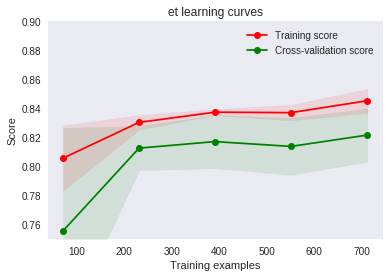

In [14]:
g = plot_learning_curve(et,"et learning curves",x_train,y_train,cv=cv,ylim=ylim(0.75,0.9),
                       train_sizes=np.linspace(.1, 1.0, 5))

In [16]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
rf_params = {'n_jobs': 10, 'min_samples_leaf': 2, 'n_estimators': 503, 'max_features': 15, 'random_state': 7, 'criterion': 'gini', 'min_samples_split': 22, 'max_depth': 4}
rf = RandomForestClassifier(**rf_params)
rf_oof_train, rf_oof_test = get_oof(rf,x_train,y_train,test)

0.830527497194


In [ ]:
rf_params1={'max_features': 14, 'n_estimators': 500, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 6}
rf1 = RandomForestClassifier(**rf_params1)
rf_oof_train1, rf_oof_test1 = get_oof(rf1,x_train,y_train,test)

In [ ]:
rf_params2={'max_features': 12, 'n_estimators': 502, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 4}
rf2 = RandomForestClassifier(**rf_params2)
rf_oof_train2, rf_oof_test2 = get_oof(rf2,x_train,y_train,test)

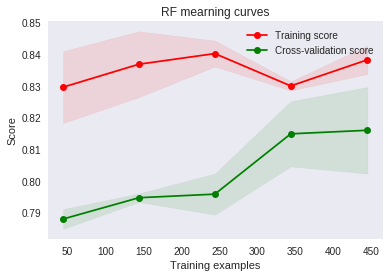

In [32]:
g = plot_learning_curve(rf,"RF mearning curves",x_train,y_train,cv=cv,train_sizes=np.linspace(.1, 1.0, 5))

In [17]:
ada_params = {
    'n_estimators': 1000,
    'learning_rate' : 0.75
}
ada_params = {'n_estimators': 781, 'learning_rate': 0.021604161737262997, 'random_state': 7, 'algorithm': 'SAMME'}
ada = AdaBoostClassifier(**ada_params)
ada_oof_train, ada_oof_test = get_oof(ada,x_train,y_train,test)

0.833894500561


In [ ]:
g = plot_learning_curve(ada,"AdaBoost learning curves",x_train,y_train,cv=cv)

In [18]:
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}
#More trees is always better with diminishing returns. Deeper trees are almost always better
#subject to requiring more trees for similar performance.

#The above two points are directly a result of the bias-variance tradeoff. 
#Deeper trees reduces the bias; more trees reduces the variance.
gb_params={'loss': 'deviance', 'learning_rate': 0.03054478572222981, 'min_samples_leaf': 18, 'n_estimators': 525, 'max_features': 20, 'random_state': 7, 'min_samples_split': 31, 'max_depth': 1}
gb = GradientBoostingClassifier(**gb_params)
gb_oof_train, gb_oof_test = get_oof(gb,x_train,y_train,test)

0.83164983165


In [12]:
gb_params1={'n_estimators': 501, 'loss': 'deviance', 'max_features': 15, 'learning_rate': 0.0015998587196060573, 'max_depth': 9, 'min_samples_leaf': 10}
gb1 = GradientBoostingClassifier(**gb_params1)
gb_oof_train1, gb_oof_test1 = get_oof(gb1,x_train,y_train,test)

0.808080808081


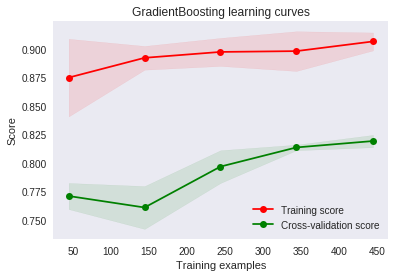

In [34]:
g = plot_learning_curve(gb,"GradientBoosting learning curves",x_train,y_train,cv=cv)

In [21]:
svc_params = {'kernel': 'rbf', 'C': 16072.397861856223, 'random_state': 7, 'gamma': 0.0009972572012118043}
svc = SVC(**svc_params)
svc_oof_train, svc_oof_test = get_oof(svc,x_train,y_train,test)


0.833894500561


In [ ]:
g = plot_learning_curve(svc,"SVC learning curves",x_train,y_train,cv=cv,
                        train_sizes=np.linspace(.1, 1.0, 5))

**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [17]:
rf_features = rf.feature_importances_
et_features = et.feature_importances_
ada_features = ada.feature_importances_
gb_features = gb.feature_importances_
'''print len(gb_features)
print gb_features
print len(ada_features)
print et_features
print rf_features'''

'print len(gb_features)\nprint gb_features\nprint len(ada_features)\nprint et_features\nprint rf_features'

In [18]:
cols = dataset.columns.values[1:]
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'rf': rf_features,
     'et': et_features,
      'ada': ada_features,
    'gb': gb_features
    })
feature_dataframe = feature_dataframe[['features','rf','et','ada','gb']]
#feature_dataframe = feature_dataframe[['features','rf','et','gb']]
feature_dataframe.head()

,features,rf,et,ada,gb
0,Sex,0.236108,0.230345,0.001,0.088380
1,Fare,0.022961,0.006230,0.082,0.057575
2,SibSp0,0.001957,0.002848,0.021,0.019286
3,SibSp1,0.001704,0.004295,0.001,0.016169
4,SibSp2,0.015825,0.020312,0.004,0.013327


**Interactive feature importances via Plotly scatterplots**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers 

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe

In [19]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe.sort_values('et',ascending=False)
important = feature_dataframe.sort_values('mean',ascending=False)
#print important
important['features'].values

array(['Title_men', 'Sex', 'Title_girl', 'Title_women', 'Pc_3', 'Fare',
       'Cabin_X', 'Em_S', 'Fsize4', 'Fsize0', 'T_3', 'name_(10, 20]',
       'Parch3', 'name_(40, 50]', 'T_2', 'Em_C', 'Cabin_D', 'Pc_1', 'T_1',
       'Age_(0, 10]', 'Cabin_C', 'Parch0', 'SibSp2', 'Title_Master',
       'Age_(-10, 0]', 'SibSp0', 'Cabin_B', 'Pc_2', 'Fsize2',
       'name_(30, 40]', 'T_P', 'Cabin_E', 'Fsize1', 'Fsize3', 'Parch1',
       'name_(50, 100]', 'SibSp1', 'T_A', 'Parch2'], dtype=object)

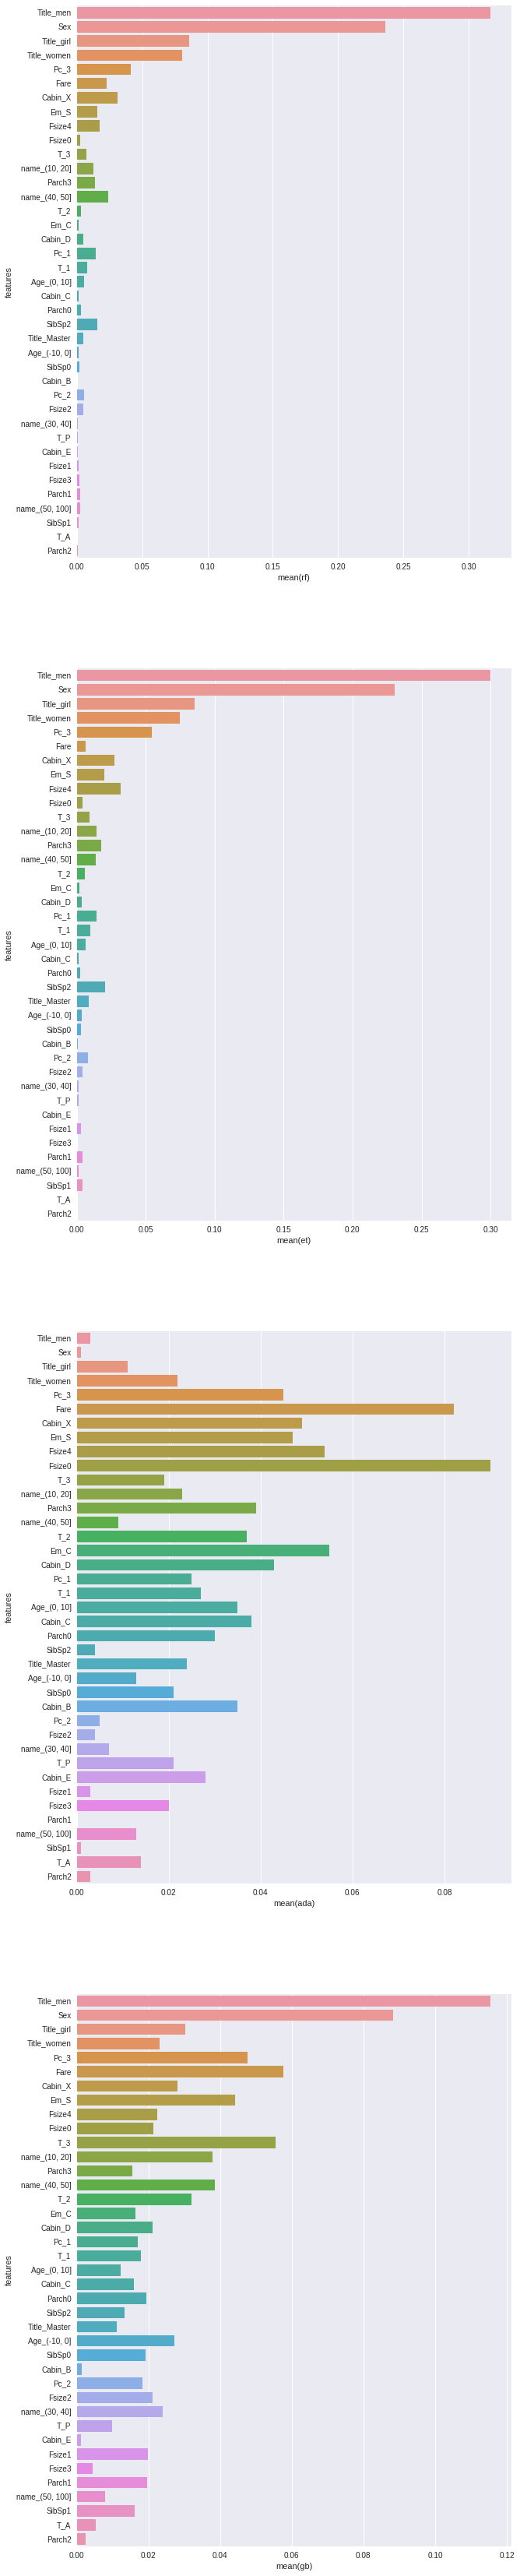

In [20]:
_,ax=plt.subplots(4,1,figsize=(30,60))
_.set_size_inches(10, 60)
for i,classify in enumerate(important.columns.values[1:5]):
    sns.barplot(y='features',x=classify,data=important,ax=ax[i])

In [ ]:
print et_oof_train.shape
x_train_stack = np.concatenate(( et_oof_train,et_oof_train1, 
                                rf_oof_train,rf_oof_train1,rf_oof_train2,
                                gb_oof_train,gb_oof_train1,
                               ada_oof_train,svc_oof_train), axis=1)
x_test_stack = np.concatenate(( et_oof_test,et_oof_test1, 
                               rf_oof_test,rf_oof_test1,rf_oof_test2,
                               gb_oof_test,gb_oof_test1,
                              ada_oof_test,svc_oof_test), axis=1)
print x_train_stack.shape
print x_test_stack.shape

In [34]:
print et_oof_train.shape
x_train_stack = np.concatenate(( et_oof_train, 
                                rf_oof_train,
                                gb_oof_train,
                               ada_oof_train,svc_oof_train), axis=1)
x_test_stack = np.concatenate(( et_oof_test, 
                               rf_oof_test,
                               gb_oof_test,
                              ada_oof_test,svc_oof_test), axis=1)
print x_train_stack.shape
print x_test_stack.shape

(891, 1)
(891, 5)
(418, 5)


In [35]:
print et_oof_train.shape
x_train_stack = np.concatenate(( et_oof_train, 
                                rf_oof_train,gb_oof_train), axis=1)
x_test_stack = np.concatenate(( et_oof_test, 
                               rf_oof_test,gb_oof_test), axis=1)
print x_train_stack.shape
print x_test_stack.shape

(891, 1)
(891, 3)
(418, 3)


In [35]:
space4xgb = {
    'max_features': hp.choice('max_features', range(4,20)),
    'n_estimators': hp.choice('n_estimators', range(2000,3000),
    'learning_rate': hp.loguniform('learning_rate', -3*np.log(10), -1*np.log(10)),
    "max_depth": hp.choice('max_depth', range(3,20)),
    'min_child_weight': hp.choice('min_samples_leaf',range(2,20)),
    'gamma':hp.choice('gamma',[0.8,0.9,1.0]),
    'colsample_bytree':hp.choice('colsample_bytree',[0.8,0.9,1.0]),
    'subsample':hp.choice('subsample',[0.8,0.9,1.0]),
    'objective':hp.choice('objective',['binary:logistic']),
     'nthread':hp.choice('nthread',[-1]),
     'scale_pos_weight':hp.choice('scale_pos_weight',[1])
}

best = 0
def f(params):
    global best
    clf = xgb.XGBClassifier(**params)
    acc = cross_val_score(clf, x_train_stack, y_train,cv=cv,n_jobs=-1).mean()
    if acc > best:
        best = acc
        print 'new best:', best, params
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4xgb, algo=tpe.suggest, max_evals=50, trials=trials)
print 'best:'
print best

new best: 0.824974758732 {'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.068664884500429985, 'nthread': -1, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8, 'objective': 'binary:logistic', 'max_depth': 8, 'gamma': 0.9}
new best: 0.824981035802 {'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.086851137375135251, 'nthread': -1, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8, 'objective': 'binary:logistic', 'max_depth': 8, 'gamma': 0.9}
new best: 0.826098354237 {'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.082864277285468427, 'nthread': -1, 'min_child_weight': 2, 'n_estimators': 2000, 'subsample': 0.8, 'objective': 'binary:logistic', 'max_depth': 3, 'gamma': 0.9}
best:
{'colsample_bytree': 0, 'scale_pos_weight': 0, 'learning_rate': 45, 'nthread': 0, 'min_samples_leaf': 0, 'n_estimators': 0, 'subsample': 0, 'objective': 0, 'max_depth': 0, 'gamma': 1}


In [ ]:
paramxgb={'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'learning_rate': 0.0517947467923121, 'nthread': -1, 'min_child_weight': 9, 'n_estimators': 2000, 'subsample': 0.8, 'objective': 'binary:logistic', 'max_depth': 3, 'gamma': 0.9}
gbm = xgb.XGBClassifier(**paramxgb)
gbm.fit(x_train_stack, y_train)
predictions = gbm.predict(x_test_stack)
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("titanic.csv", index=False)

In [23]:
gbm = xgb.XGBClassifier(
 learning_rate = 0.1,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train_stack, y_train)
print accuracy_score(gbm.predict(x_train_stack),y_train)
predictions = gbm.predict(x_test_stack)
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("titanic.csv", index=False)

0.836139169473


In [35]:
#print accuracy_score(ytest,predictions)

In [109]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
rf = RandomForestClassifier(**rf_params)
rf.fit(x_train,y_train)
rfpredict = rf.predict(test)

StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': rf_oof_test.reshape(-1).astype(int)})
StackingSubmission.to_csv("titanic.csv", index=False)

In [33]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived':gb_oof_test.reshape(-1).astype(int)})
StackingSubmission.to_csv("titanic.csv", index=False)

**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.